In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import wandb

In [2]:
df = pd.read_csv("sdreDataset.csv", names=range(1, 10))

In [3]:
traj_system = df.values[:, 0:6]
control_system = df.values[:, 6:]
traj_system.shape, control_system.shape

((20200, 6), (20200, 3))

In [4]:
traj_system[0, :], control_system[0, :]

(array([ 0.62944737,  0.81158387, -0.74602637,  0.07124575, -0.06913249,
         0.06910579]),
 array([-1.72598724, -2.14473359,  2.07397462]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        traj_system, control_system, test_size=0.2, random_state=42, shuffle=False)

In [6]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
train_dataset[0]

(tensor([ 0.6294,  0.8116, -0.7460,  0.0712, -0.0691,  0.0691]),
 tensor([-1.7260, -2.1447,  2.0740]))

In [8]:
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(test_dataset, 
                          batch_size=64)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DummyModel(nn.Module):
    def __init__(self, input_dim=6, 
                 output_dim=3, 
                 hidden_dim=16) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class DummyModel2(nn.Module):
    def __init__(self, input_dim=6, 
                 output_dim=3, 
                 hidden_dim_1=16,
                 hidden_dim_2=16,
                 dropout_rate=0) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

In [10]:
from tqdm import tqdm

def train_epoch():
    model.train()

    running_loss = 0.
    n_ep_it_loss = 300

    # for i, (X, y) in enumerate(tqdm(train_loader)):
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)
        loss = criteria(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # if i % n_ep_it_loss == n_ep_it_loss - 1:
        #     print("train loss = ", running_loss / n_ep_it_loss)
        #     running_loss = 0.

In [11]:
from tqdm import tqdm

def eval_epoch():
    model.eval()
    losses = []
    # for i, (X, y) in enumerate(tqdm(test_loader)):
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(X)
        loss = criteria(output, y)
        losses.append(loss)

    mean_loss = sum(losses) / len(losses)
    # print("eval losss = ", mean_loss)
    return mean_loss

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = DummyModel(hidden_dim=256)
model = DummyModel2(hidden_dim_1=128, 
                   hidden_dim_2=128)
model.to(device)
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [13]:
model

DummyModel2(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0, inplace=False)
)

In [14]:
wandb_loggging = True
if wandb_loggging:
    project_name = "SDRE_Approx"
    run_name = "MLP 6-128-128-3"

    wandb.login()
    wandb.init(project=project_name,
               name=run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: petili. Use `wandb login --relogin` to force relogin


In [15]:
eval_history = []
val_loss = eval_epoch()
eval_history.append(val_loss)

if wandb_loggging:
    wandb.log({
        "val_loss": val_loss,
        "epoch" : 0
        })

In [16]:
for epoch in range(100):
# for epoch in range(800, 1000):
    train_epoch()
    val_loss = eval_epoch()
    print(f"eval losss on epoch {epoch} = ", val_loss)
    eval_history.append(val_loss)

    if wandb_loggging:
        wandb.log({
            "val_loss": val_loss,
            "epoch" : epoch
            })

eval losss on epoch 0 =  tensor(0.0097)
eval losss on epoch 1 =  tensor(0.0077)
eval losss on epoch 2 =  tensor(0.0071)
eval losss on epoch 3 =  tensor(0.0063)
eval losss on epoch 4 =  tensor(0.0058)
eval losss on epoch 5 =  tensor(0.0063)
eval losss on epoch 6 =  tensor(0.0056)
eval losss on epoch 7 =  tensor(0.0056)
eval losss on epoch 8 =  tensor(0.0056)
eval losss on epoch 9 =  tensor(0.0060)
eval losss on epoch 10 =  tensor(0.0058)
eval losss on epoch 11 =  tensor(0.0057)
eval losss on epoch 12 =  tensor(0.0059)
eval losss on epoch 13 =  tensor(0.0060)
eval losss on epoch 14 =  tensor(0.0059)
eval losss on epoch 15 =  tensor(0.0055)
eval losss on epoch 16 =  tensor(0.0063)
eval losss on epoch 17 =  tensor(0.0056)
eval losss on epoch 18 =  tensor(0.0058)
eval losss on epoch 19 =  tensor(0.0054)
eval losss on epoch 20 =  tensor(0.0056)
eval losss on epoch 21 =  tensor(0.0063)
eval losss on epoch 22 =  tensor(0.0055)
eval losss on epoch 23 =  tensor(0.0057)
eval losss on epoch 24 =  

KeyboardInterrupt: 

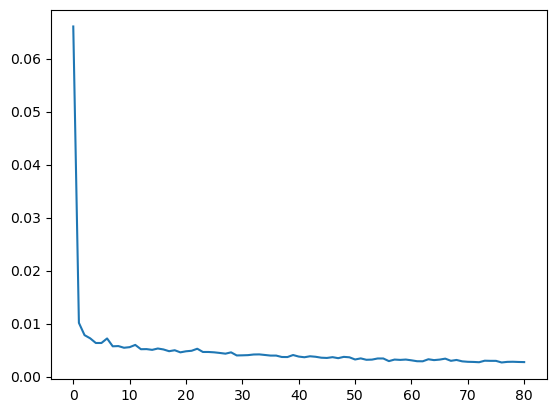

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_history)